In [1]:
import sys
import time
from copy import deepcopy

import numpy as np

from scipy.cluster.vq import kmeans2
from scipy.cluster.hierarchy import linkage
from scipy.io import mmread
from scipy import stats

from sklearn.cluster import SpectralClustering
from sklearn.manifold import t_sne
from sklearn.decomposition import PCA

try: del sys.modules['sc_em'] # change this to your module's (<ex2_id>) name to reload module changes
except KeyError: pass 
from sc_em import * # and here too (<ex2_id>)
from sklearn.manifold import t_sne

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython import display
%matplotlib inline

# Exploring Single Cell Data

In [2]:
# import the data, remove all-zeros lines, and conert to full matrix format
scd = mmread('muris-Lung-10X_P7_9.mtx')
scd = np.asarray(scd.todense())
scd = scd[scd.sum(1)>0,:]
genes = [l.strip().split('\t')[0] for l in open('genes.tsv')]

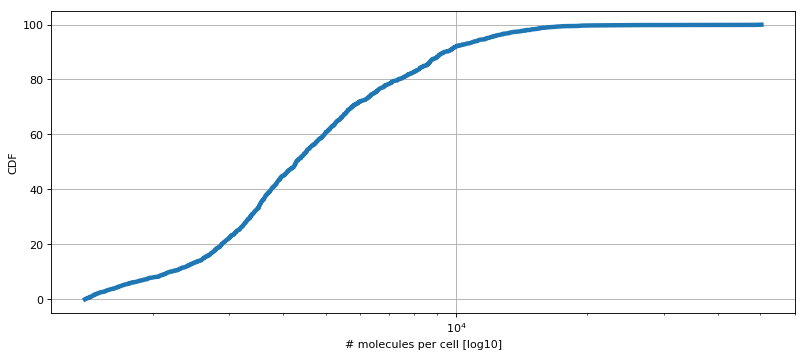

In [119]:
# plot cell molecule CDF
fig = plt.figure(figsize=(12,5), dpi=80, facecolor='w', edgecolor='k');
x = np.sort(scd.sum(0))
plt.semilogx(x, 100*np.arange(len(x))/len(x), lw=4)
plt.grid('on')
plt.xlabel('# molecules per cell [log10]')
plt.ylabel('CDF');

In [93]:
# dim reductions, might take some time...
t = t_sne.TSNE(n_components=2).fit_transform(np.log(1+scd.T))
p = PCA(n_components=2).fit(np.log(1+scd.T)).transform(np.log(1+scd.T))

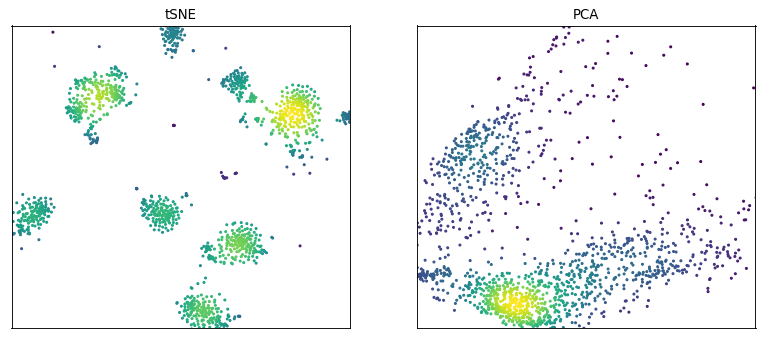

In [120]:
# and plot dim reductions
fig = plt.figure(figsize=(12,5), dpi=80, facecolor='w', edgecolor='k');

plt.subplot(121)
c = stats.gaussian_kde(t.T)(t.T) # get smoothed density for coloring
plt.scatter(t[:,0],t[:,1],c=c,s=3)
plt.title('tSNE')
plt.xlim(np.percentile(t[:,0],[1, 99]))
plt.ylim(np.percentile(t[:,1],[1, 99]))
plt.xticks([])
plt.yticks([])

plt.subplot(122)
c = stats.gaussian_kde(p.T)(p.T)
plt.scatter(p[:,0],p[:,1],c=c,s=3)
plt.title('PCA')
plt.xlim(np.percentile(p[:,0],[1, 99])) # plot only the bulk of the data
plt.ylim(np.percentile(p[:,1],[1, 99]))
plt.xticks([])
plt.yticks([]);

In [123]:
# get density for poisson analysis, might take some time...
x = ??
y = ??
xy = np.log10(np.vstack([x,y])) # Calculate the point density
c = stats.gaussian_kde(xy)(xy);

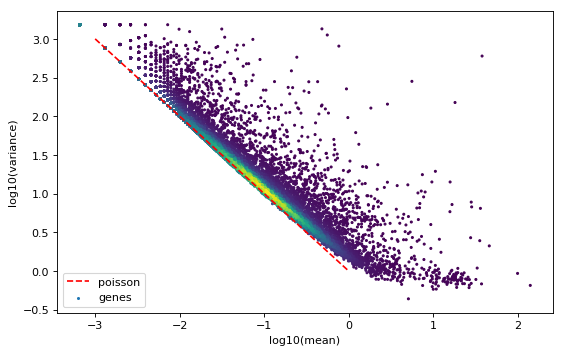

In [131]:
# and plot the results
fig = plt.figure(figsize=(8,5), dpi=80, facecolor='w', edgecolor='k');

plt.scatter(np.log10(x), np.log10(y), c=c, s=3)
poiss_x = [??]
poiss_y = [??]
plt.plot(poiss_x, poiss_y, 'r--');
plt.xlabel('log10(mean)')
plt.ylabel('log10(variance)');
plt.legend(['poisson','genes'],loc='lower left');

In [1]:
# choose genes, plot some stuff to explain how you chose them, consider their variance and their expression level...


# Generative Single Cell RNA Model

## Sampling

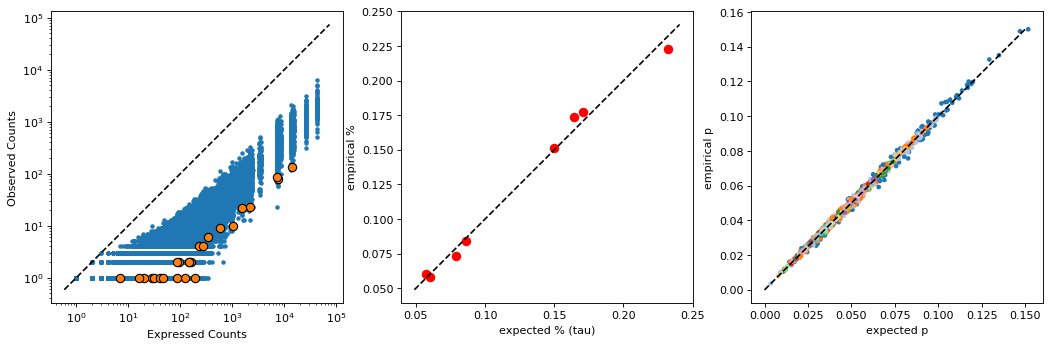

In [28]:

#sample data from your model
m = SingleCellExpressionModel(C=1000, G=200, T=8)
x, y, t = m.sample()

#and plot some proof that it's working properly
fig = plt.figure(figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot('131')
plt.loglog(y.ravel(),x.ravel(),'.')
plt.loglog(y[:,0],x[:,0],'.', ms=15, markeredgecolor='k')
plt.plot(plt.xlim(),plt.xlim(),'k--')
plt.axis('square')
plt.xlabel('Expressed Counts')
plt.ylabel('Observed Counts')

ax = plt.subplot('132')
??

ax = plt.subplot('133')
??

In [4]:
# sample data and apply k-means, does it work?
T = 8
m = SingleCellExpressionModel(C=1000, G=200, T=T)
x,y,t = m.sample()

fig=plt.figure(figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')

## EM

### Validating the likelihood function

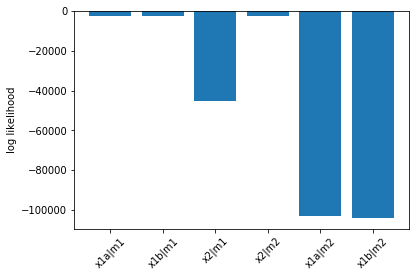

In [29]:
m1 = SingleCellExpressionModel(C=100, G=50, T=5)
m2 = SingleCellExpressionModel(C=100, G=50, T=5)
x1a, _, _ = m1.sample()
x1b, _, _ = m1.sample()
x2, _, _ = m2.sample()
labels = ['x1a|m1','x1b|m1','x2|m1','x2|m2','x1a|m2','x1b|m2']
ll = [m1.loglikelihood(x1a),
      m1.loglikelihood(x1b),
      m1.loglikelihood(x2),
      m2.loglikelihood(x2),
      m2.loglikelihood(x1a),
      m2.loglikelihood(x1b)]
plt.bar(range(len(ll)),ll)
ax = plt.gca()
ax.set_xticks(range(len(ll)))
ax.set_xticklabels(labels, rotation=45)
plt.ylabel('log likelihood');

### Assert that likelihood is improving

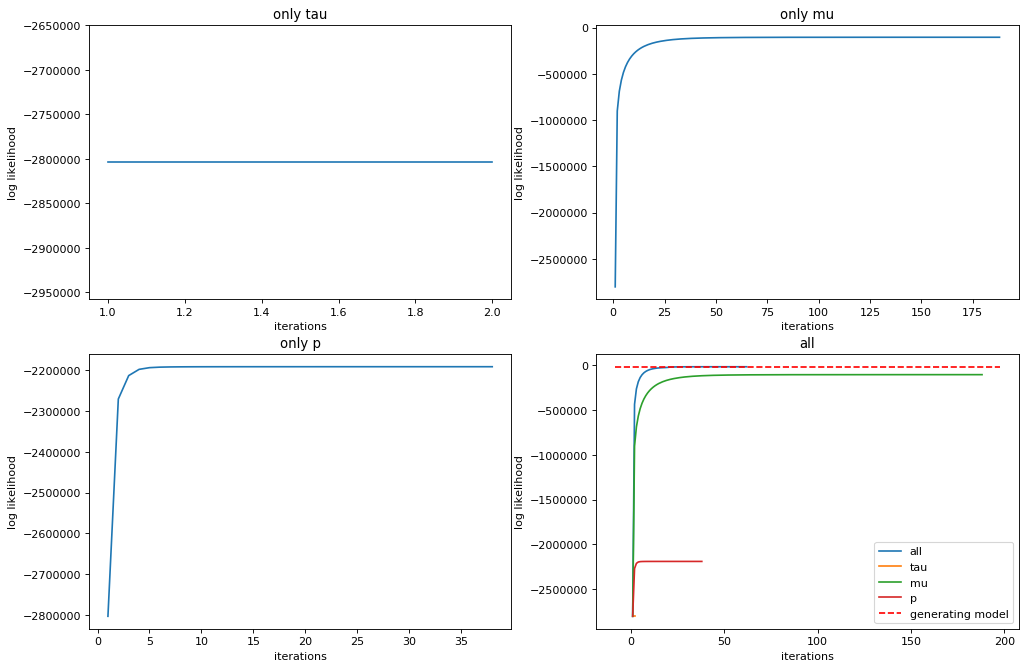

In [36]:
fig = plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
m0 = SingleCellExpressionModel(C=500, G=50, T=5)
x, _, _ = m0.sample()
ll_opt = m0.loglikelihood(x)
m = SingleCellExpressionModel(C=500, G=50, T=5)

plt.subplot('221')
ll1 = deepcopy(m).learn(x, learn_params='tau')
plt.plot(ll1)
plt.title('only tau')
plt.xlabel('iterations')
plt.ylabel('log likelihood')

plt.subplot('222')
ll2 = deepcopy(m).learn(x, learn_params='mu')
plt.plot(ll2)
plt.title('only mu')
plt.xlabel('iterations')
plt.ylabel('log likelihood')

plt.subplot('223')
ll3 = deepcopy(m).learn(x, learn_params='p')
plt.plot(ll3)
plt.title('only p')
plt.xlabel('iterations')
plt.ylabel('log likelihood')

plt.subplot('224')
ll = deepcopy(m).learn(x)
plt.plot(ll)
plt.plot(ll1)
plt.plot(ll2)
plt.plot(ll3)
plt.plot(plt.xlim(), [ll_opt, ll_opt], 'r--')
plt.title('all')
plt.xlabel('iterations')
plt.ylabel('log likelihood')
plt.legend(['all','tau','mu','p','generating model']);

### Verify that process doesn't diverge from a local minimum

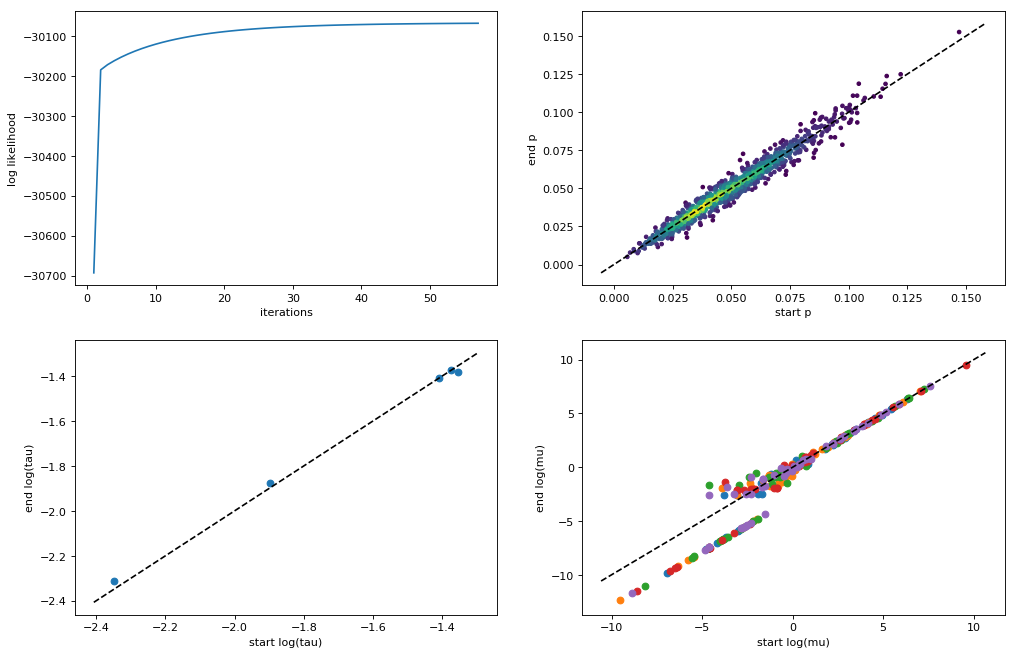

In [37]:
fig = plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.set_cmap('viridis')
m = SingleCellExpressionModel(C=1000, G=50, T=5)
m0 = copy.deepcopy(m)
x, _, t = m.sample()
ll = m.learn(x)
plt.subplot('221')
plt.plot(ll)
plt.xlabel('iterations')
plt.ylabel('log likelihood')

plt.subplot('222')
xy = np.vstack([m0.p,m.p]) # for calculating the point density
plt.scatter(m0.p.ravel(), m.p.ravel(), c=stats.gaussian_kde(xy)(xy), s=10)
plt.plot(plt.xlim(),plt.xlim(),'k--')
plt.xlabel('start p')
plt.ylabel('end p')

plt.subplot('223')
plt.scatter(m0.log_tau, m.log_tau)
plt.plot(plt.xlim(),plt.xlim(),'k--')
plt.xlabel('start log(tau)')
plt.ylabel('end log(tau)')

plt.subplot('224')
for ti in range(m.T):
    plt.scatter(np.log(m0.mu[:,ti]), np.log(m.mu[:,ti]))
plt.plot(plt.xlim(),plt.xlim(),'k--')
plt.xlabel('start log(mu)')
plt.ylabel('end log(mu)');

### Learn with simulated data from multiple start points

Text(0.5,0,'# types')

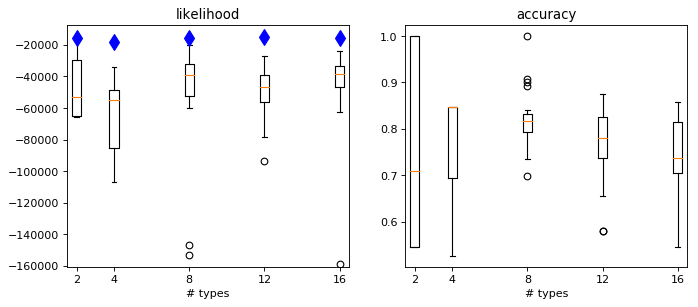

In [179]:
fig = plt.figure(figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')

N = 20
trange = [2, 4, 8, 12, 16] #different number of cell types
print_every = 50

def print_iter(ll, *args):
    if len(ll) % print_every != 0: return
    print('iteration %i: %.2f' % (len(ll), ll[-1]))
    
ll, r_ll, acc = [], [], []
for t in trange:
    t_ll, n_models, t_acc = [], [], []
    m = SingleCellExpressionModel(C=500, G=50, T=t)
    x, _, types = m.sample()
    r_ll.append(m.loglikelihood(x))
    print('=' * 15 + ' %i ' % t + '=' * 15)
    for n in range(N):
        m0 = SingleCellExpressionModel(C=m.C, G=m.G, T=m.T)
        tn_ll = m0.learn(x, report=print_iter)
        t_ll.append(tn_ll[-1])
        cm = confusion_matrix(m0.type_posterior(x).argmax(1), types + 1)
        # reorder types, sum diagonal and divide by #cells, this is the model accuracy
        t_acc.append(np.diag(cm[:,cm.argmax(1)]).sum() / len(types))
        print('-' * 15)
    display.clear_output(wait=True)
    ll.append(t_ll)
    acc.append(t_acc)

display.clear_output(wait=True)
plt.subplot('121')
plt.boxplot(ll, positions=trange)
plt.plot(trange, r_ll, 'db', ms=10);
plt.ylim([np.percentile(np.asarray(ll), 5),max(np.asarray(ll).max(),max(r_ll))*0.5])
plt.title('likelihood')
plt.xlabel('# types')

plt.subplot('122')
plt.boxplot(acc, positions=trange)
plt.title('accuracy');

### Introduce noise during optimization

Text(0,0.5,'log likelihood')

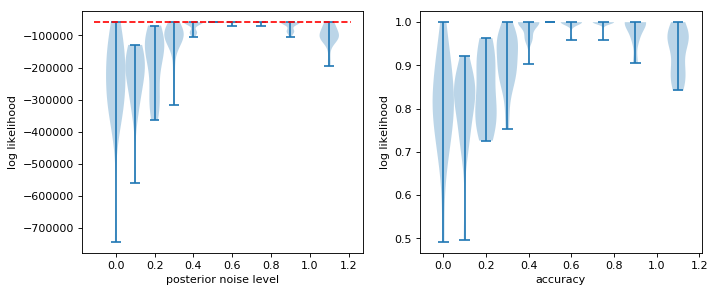

In [251]:
m = SingleCellExpressionModel(C=1000, G=100, T=8)
N = 20
x, _, types = m.sample()
m_ll = m.loglikelihood(x)
nrange = [0, .1, .2, .3, .4 ,.5, .6, .75, .9, 1.1]
e = lambda: np.empty((N, len(nrange)))

results = {'ll': e(), 'acc': e()}
for ni, noise_amp in enumerate(nrange):
    print("==== noise: %.2f ======" % noise_amp)
    for n in range(N):
        m0 = SingleCellExpressionModel(C=m.C, G=m.G, T=m.T)
        m0.learn(x, noise_amp=noise_amp, tolerance=1)
        ll = m0.learn(x)
        print("ll: %.2f" % ll[-1])
        results['ll'][n,ni] = ll[-1]
        cm = confusion_matrix(m0.type_posterior(x).argmax(1), types + 1)
        results['acc'][n,ni] = np.diag(cm[:,cm.argmax(1)]).sum() / len(types)
    display.clear_output(wait=True);

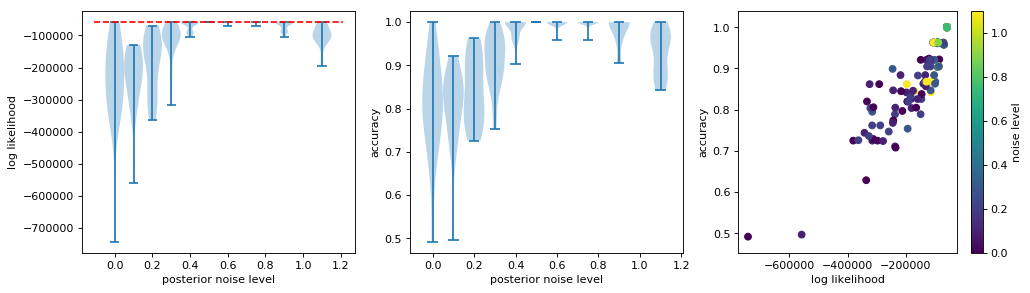

In [475]:
fig = plt.figure(figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k');
plt.subplot(1,3,1)
plt.violinplot(results['ll'], positions=nrange, widths=.1)
plt.plot(plt.xlim(), [m_ll, m_ll], 'r--')
plt.xlabel('posterior noise level')
plt.ylabel('log likelihood')

plt.subplot(1,3,2)
plt.violinplot(results['acc'], positions=nrange, widths=.1)
plt.xlabel('posterior noise level')
plt.ylabel('accuracy');

plt.subplot(1,3,3)
c = np.tile(nrange, (N,1))
i, j = np.unravel_index(rnd.permutation(N*len(nrange)), c.shape) # permute points to avoid a layout bias on the plot
plt.scatter(results['ll'][i,j], results['acc'][i,j], c=c[i,j])
plt.ylabel('accuracy')
plt.xlabel('log likelihood');
cbar = plt.colorbar()
cbar.set_label('noise level')

# Model Real data